In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from sklearn.metrics import r2_score
import bayesflow as bf

import sys
sys.path.append("../../../assets")
sys.path.append("../")
from experiments import NonStationaryDDMExperiment
from models import MixtureRandomWalkDDM, RegimeSwitchingDDM, RandomWalkDDM
from helpers import get_setup
from configurations import model_names

/Users/lschumacher/miniconda3/envs/beef/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
%load_ext autoreload
%autoreload 2
# Suppress scientific notation for floats
np.set_printoptions(suppress=True)
# Configure rng
RNG = np.random.default_rng()

In [3]:
CROSS_FITTING = True

In [4]:
NUM_OBS = 768
NUM_SUBS = 14
NUM_SAMPLES = 500
NUM_SIM = 100

LOCAL_PARAM_LABELS = ['Drift rate', 'Threshold', 'Non-decision time']
LOCAL_PARAM_NAMES  = [r'v', r'a', r'\tau']

FONT_SIZE_1 = 18
FONT_SIZE_2 = 16
FONT_SIZE_3 = 14

import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "sans-serif"

## Closed World

### Get Model Setup

In [5]:
mrw_model = MixtureRandomWalkDDM()
mrw_trainer = NonStationaryDDMExperiment(
    mrw_model,
    summary_network_type="smoothing",
    checkpoint_path="../checkpoints/smoothing_mixture_random_walk_ddm",
    skip_checks=True
)

INFO:root:Performing 2 pilot runs with the mixture_random_walk_ddm model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 800, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 800)
INFO:root:Shape of hyper_prior_draws batch after 2 pilot simulations: (batch_size = 2, 5)
INFO:root:Shape of local_prior_draws batch after 2 pilot simulations: (batch_size = 2, 800, 3)
INFO:root:No shared_prior_draws provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional prior non-batchable context provided.
INFO:root:Loaded loss history from ../checkpoints/smoothing_mixture_random_walk_ddm/history_75.pkl.
INFO:root:Networks loaded from ../checkpoints/smoothing_mixture_random_walk_ddm/ckpt-75


In [6]:
rs_model = RegimeSwitchingDDM()
rs_trainer = NonStationaryDDMExperiment(
    rs_model,
    summary_network_type="smoothing",
    checkpoint_path="../checkpoints/smoothing_regime_switching_ddm",
    skip_checks=True
)

INFO:root:Performing 2 pilot runs with the regime_switching_ddm model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 800, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 800)
INFO:root:Shape of hyper_prior_draws batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of local_prior_draws batch after 2 pilot simulations: (batch_size = 2, 800, 3)
INFO:root:No shared_prior_draws provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional prior non-batchable context provided.
INFO:root:Loaded loss history from ../checkpoints/smoothing_regime_switching_ddm/history_75.pkl.
INFO:root:Networks loaded from ../checkpoints/smoothing_regime_switching_ddm/ckpt-75


### Data Simulation

In [7]:
mrw_data = mrw_model.generate(NUM_SIM)
rs_data = rs_model.generate(NUM_SIM)
validation_data = [mrw_data, rs_data]

In [8]:
true_mrw_data_params = mrw_data['local_prior_draws']
true_rs_data_params = rs_data['local_prior_draws']
true_params = [true_mrw_data_params, true_rs_data_params]

### Cross Fitting

In [9]:
if CROSS_FITTING:
    posterior_samples = []
    with tf.device('/cpu:0'):
        for i in range(len(validation_data)):
            mrw_post_samples = np.zeros((NUM_SIM, 800, NUM_SAMPLES, 3))
            rs_post_samples = np.zeros((NUM_SIM, 800, NUM_SAMPLES, 3))
            for j in tqdm(range(NUM_SIM)):
                mrw_post_samples[j] = mrw_trainer.amortizer.sample(
                    {"summary_conditions": validation_data[i]['sim_data'][j:j+1][:, :, None]},
                    NUM_SAMPLES
                )['local_samples']
                rs_post_samples[j] = rs_trainer.amortizer.sample(
                    {"summary_conditions": validation_data[i]['sim_data'][j:j+1][:, :, None]},
                    NUM_SAMPLES
                )['local_samples']
            posterior_samples.append(mrw_post_samples * mrw_model.local_prior_stds + mrw_model.local_prior_means)
            posterior_samples.append(rs_post_samples * rs_model.local_prior_stds + rs_model.local_prior_means)
    with open('../data/posteriors/posterior_samples_cross_fitting.pkl', 'wb') as file:
        pickle.dump(posterior_samples, file)
else:
    with open('../data/posteriors/posterior_samples_cross_fitting.pkl', 'rb') as file:
        posterior_samples = pickle.load(file)

100%|██████████| 100/100 [36:26<00:00, 21.86s/it]


### Evaluation

In [10]:
mrw_well = 1 / (np.max(np.median(posterior_samples[0], axis=2), axis=0) - np.min(np.median(posterior_samples[0], axis=2), axis=0)) * np.sqrt(
    np.mean((np.median(posterior_samples[0], axis=2) - true_mrw_data_params)**2, axis=0)
)

mrw_miss = 1 / (np.max(np.median(posterior_samples[2], axis=2), axis=0) - np.min(np.median(posterior_samples[2], axis=2), axis=0)) * np.sqrt(
    np.mean((np.median(posterior_samples[2], axis=2) - true_rs_data_params)**2, axis=0)
)

rs_well = 1 / (np.max(np.median(posterior_samples[3], axis=2), axis=0) - np.min(np.median(posterior_samples[3], axis=2), axis=0)) * np.sqrt(
    np.mean((np.median(posterior_samples[3], axis=2) - true_rs_data_params)**2, axis=0)
)

rs_miss = 1 / (np.max(np.median(posterior_samples[1], axis=2), axis=0) - np.min(np.median(posterior_samples[1], axis=2), axis=0)) * np.sqrt(
    np.mean((np.median(posterior_samples[1], axis=2) - true_mrw_data_params)**2, axis=0)
)

nrmse = [mrw_well, mrw_miss, rs_well, rs_miss]

In [11]:
subfigure_titles = ["Mixture random walk DDM", "Regime switching DDM"]

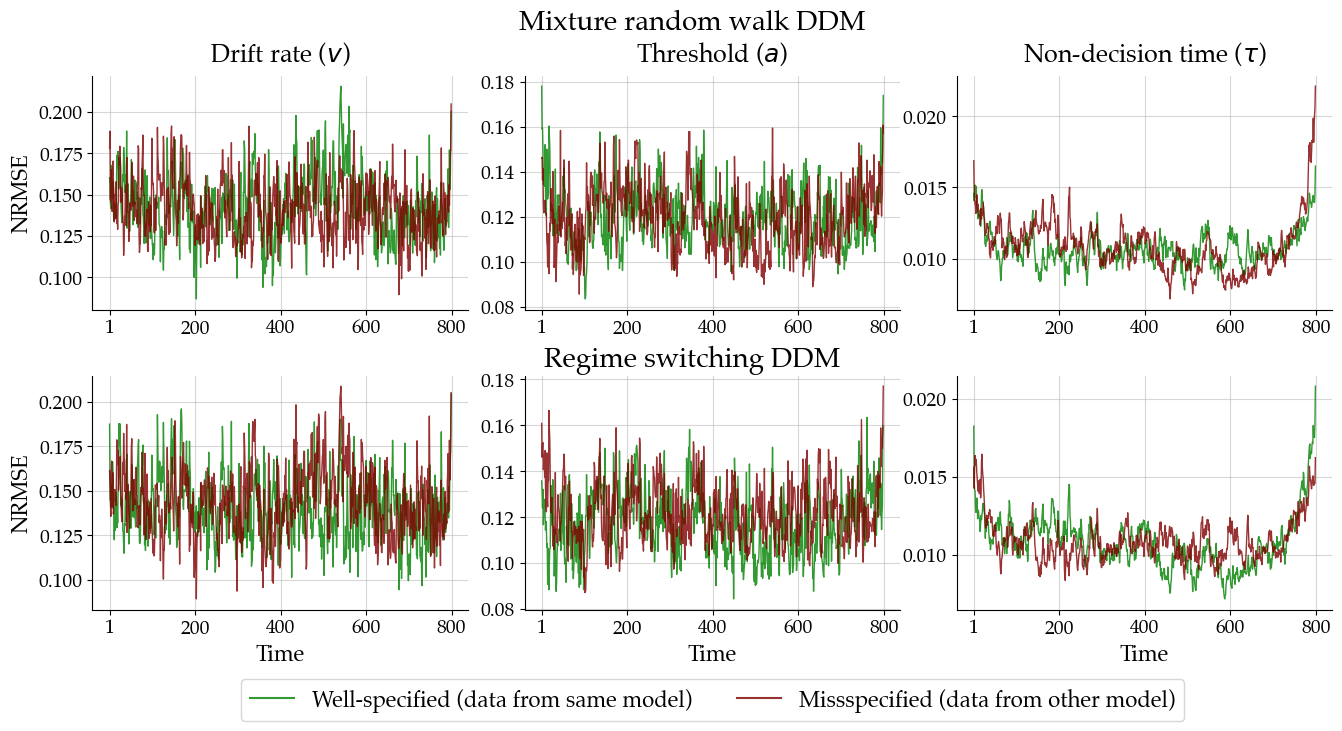

In [12]:
time = np.arange(800)
handles = [
        Line2D(xdata=[], ydata=[], color="green", alpha=0.8, label="Well-specified (data from same model)"),
        Line2D(xdata=[], ydata=[], color='maroon', alpha=0.8, label="Missspecified (data from other model)")
]
fig = plt.figure(figsize=(16, 6))
# create 4x1 subfigs
subfigs = fig.subfigures(nrows=2, ncols=1)
for row, subfig in enumerate(subfigs):
    if row == 0:
        subfig.suptitle(subfigure_titles[row], fontsize=20, fontweight='semibold', y=1.1)
    else:
        subfig.suptitle(subfigure_titles[row], fontsize=20, fontweight='semibold')

    # create 1x3 subplots per subfig
    axs = subfig.subplots(nrows=1, ncols=3)
    for col, ax in enumerate(axs):
        if row == 0:
            ax.plot(
                time, nrmse[0][:, col], color='green', alpha=0.8, lw=1
            )
            ax.plot(
                time, nrmse[1][:, col], color='maroon', alpha=0.8, lw=1
            )
        else:
            ax.plot(
                time, nrmse[2][:, col], color='green', alpha=0.8, lw=1
            )
            ax.plot(
                time, nrmse[3][:, col], color='maroon', alpha=0.8, lw=1
            )
        ax.grid(alpha=0.5)
        
        if row == 0:
            ax.set_title(f'{LOCAL_PARAM_LABELS[col]} (${LOCAL_PARAM_NAMES[col]}$)', fontsize=FONT_SIZE_1, pad=10)
        if row == 1:  
            ax.set_xlabel('Time', fontsize=FONT_SIZE_2)
        if row ==1 and col == 1:
            ax.legend(
                handles=handles, fontsize=FONT_SIZE_2, loc='upper center', 
                bbox_to_anchor=(0.5, -0.25), ncol=2
            )
        if col == 0:
            ax.set_ylabel('NRMSE', fontsize=FONT_SIZE_2)
        
        ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
        ax.set_xticks([1, 200, 400, 600, 800])
# fig.subplots_adjust(hspace=0.4)
fig.subplots_adjust(bottom=0.1, wspace=0.15, hspace=1)

sns.despine()
fig.savefig("../plots/misspecification_closed_world.pdf", dpi=300, bbox_inches="tight")

## Open World

In [13]:
with open('../data/posteriors/samples_per_model.pkl', 'rb') as file:
    samples_per_model = pickle.load(file)

In [14]:
mrw_posteriors = samples_per_model[1]['local_samples']
rs_posteriors = samples_per_model[3]['local_samples']
mrw_posteriors_median = np.median(mrw_posteriors, axis=2)
rs_posteriors_median = np.median(rs_posteriors, axis=2)

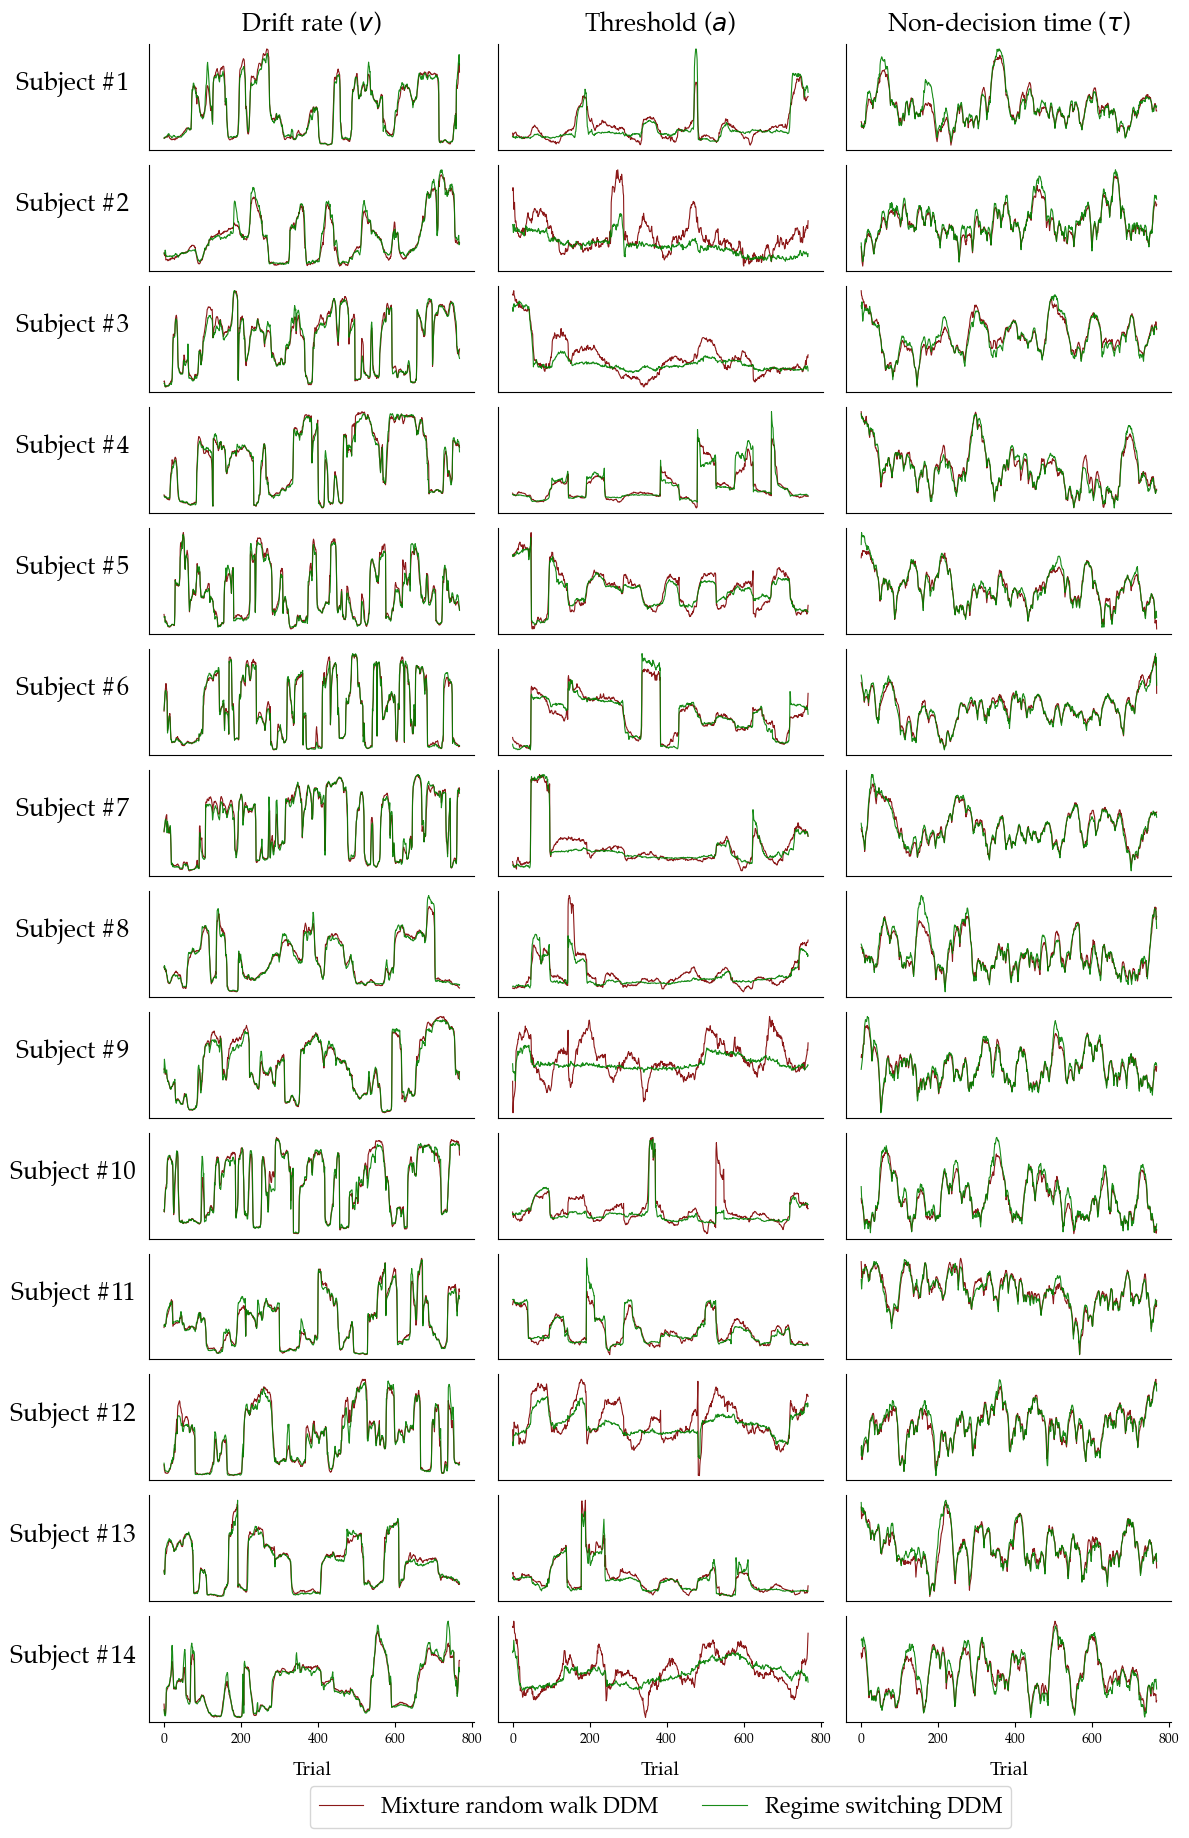

In [15]:
time = np.arange(mrw_posteriors.shape[1])
fig, ax = plt.subplots(14, 3, figsize=(12, 18))
for i in range(NUM_SUBS):
    for j in range(3):
        ax[i, j].plot(
            time, mrw_posteriors_median[i, :, j],
            color='maroon', lw=0.8, alpha=0.9,
            label="Mixture random walk DDM"
        )
        ax[i, j].plot(
            time, rs_posteriors_median[i, :, j],
            color='green', lw=0.8, alpha=0.9,
            label="Regime switching DDM"
        )
        ax[i, j].set_yticks([])
        if i == 0:
            ax[i, j].set_title(f'{LOCAL_PARAM_LABELS[j]} (${LOCAL_PARAM_NAMES[j]}$)', fontsize=FONT_SIZE_1, pad=10)
        if i < 13:
            ax[i, j].set_xticks([])
        else:
            ax[i, j].set_xlabel("Trial", labelpad=10, fontsize=FONT_SIZE_3)
    ax[i, 0].set_ylabel(f"Subject #{i+1}", labelpad=55, fontsize=FONT_SIZE_1, rotation=0)
sns.despine()
fig.tight_layout()
ax[-1, 1].legend(
    fontsize=FONT_SIZE_2, bbox_to_anchor=(0.5, -0.8),
    loc="center", ncol=2
)
fig.savefig("../plots/misspecification_open_world.pdf", dpi=300, bbox_inches="tight")